In [154]:
import tensorflow as tf
import keras as ks
from keras import models
from keras import metrics
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection

In [155]:
rawdata=pd.read_csv('/content/MSFT.csv').round(3)

In [156]:
rawdata=rawdata.dropna()
rawdata

,Date,Open,High,Low,Close,Adj Close,Volume,Interest,Currency,Inflation,Day,Month
0,1993-04-01,2.891,2.961,2.891,2.906,1.813,100412800.0,5.97,0.647,3.2,1,4
1,1993-04-02,2.867,2.875,2.805,2.805,1.750,73251200.0,5.97,0.647,3.2,2,4
2,1993-04-05,2.773,2.883,2.750,2.859,1.784,61187200.0,5.97,0.647,3.2,5,4
3,1993-04-06,2.867,2.906,2.789,2.805,1.750,55699200.0,5.97,0.647,3.2,6,4
4,1993-04-07,2.812,2.828,2.789,2.820,1.760,39417600.0,5.97,0.647,3.2,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...
7550,2023-03-27,280.500,281.460,275.520,276.380,276.380,26840200.0,3.66,0.824,5.0,27,3
7551,2023-03-28,275.790,276.140,272.050,275.230,275.230,21878600.0,3.66,0.824,5.0,28,3
7552,2023-03-29,278.960,281.140,278.410,280.510,280.510,25087000.0,3.66,0.824,5.0,29,3
7553,2023-03-30,284.230,284.460,281.480,284.050,284.050,25053400.0,3.66,0.824,5.0,30,3


In [157]:
data=pd.DataFrame()
data['Open']=rawdata['Open'].astype(np.float64)
data['High']=rawdata['High'].astype(np.float64)
data['Low']=rawdata['Low'].astype(np.float64)
data['Close']=rawdata['Close'].astype(np.float64)
data['Currency']=rawdata['Currency'].astype(np.float64)
data['Interest']=rawdata['Interest'].astype(np.float64)
data['Inflation']=rawdata['Inflation'].astype(np.float64)
data['Day']=rawdata['Day'].astype(np.int64)
data['Month']=rawdata['Month'].astype(np.int64)
data.head()

,Open,High,Low,Close,Currency,Interest,Inflation,Day,Month
0,2.891,2.961,2.891,2.906,0.647,5.97,3.2,1,4
1,2.867,2.875,2.805,2.805,0.647,5.97,3.2,2,4
2,2.773,2.883,2.750,2.859,0.647,5.97,3.2,5,4
3,2.867,2.906,2.789,2.805,0.647,5.97,3.2,6,4
4,2.812,2.828,2.789,2.820,0.647,5.97,3.2,7,4


In [158]:
train=data.iloc[:int(0.8*len(data))]
test=data.iloc[int(0.8*len(data)):]

In [159]:
def sliding_window(stockdata):
  window_size=7
  windowed_data=[]
  for i in range(len(stockdata)-window_size):
      window=stockdata[i:i+window_size]
      windowed_data.append(window)
  return np.array(windowed_data)

In [160]:
#run to keep batches ordered
X=sliding_window(train)
Y=train['Close'][7:]
TestingX=sliding_window(test)
TestingY=test['Close'][7:]

In [161]:
x_train,x_test,y_train,y_test=model_selection.train_test_split(X,Y,test_size=0.2)

In [165]:
metric=[metrics.RootMeanSquaredError(),metrics.MeanAbsoluteError(),metrics.MeanAbsolutePercentageError(),metrics.MeanSquaredLogarithmicError()]
def modelbuild():
    model = models.Sequential()
    model.add(ks.layers.LSTM(256, return_sequences=True,activation='relu', input_shape=(7,9),dropout=0.1,recurrent_dropout=0.1))
    model.add(ks.layers.SimpleRNN(32,activation='relu'))
    model.add(ks.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=metric)
    return model

In [163]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 7, 128)            70656     
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 75,841
Trainable params: 75,841
Non-trainable params: 0
_________________________________________________________________


In [166]:
model=modelbuild()
stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=[stop])
#history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test))

test_loss, rmse, mae, mape, msle = model.evaluate(x_test, y_test, verbose=2)

print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)

Epoch 1/10
151/151 [==============================] - 19s 97ms/step - loss: 27.7080 - root_mean_squared_error: 5.2638 - mean_absolute_error: 2.3779 - mean_absolute_percentage_error: 9.7613 - mean_squared_logarithmic_error: 0.1427 - val_loss: 7.4172 - val_root_mean_squared_error: 2.7235 - val_mean_absolute_error: 2.2160 - val_mean_absolute_percentage_error: 7.7818 - val_mean_squared_logarithmic_error: 0.0072
Epoch 2/10
151/151 [==============================] - 16s 108ms/step - loss: 2.0977 - root_mean_squared_error: 1.4483 - mean_absolute_error: 1.0263 - mean_absolute_percentage_error: 4.2448 - mean_squared_logarithmic_error: 0.0026 - val_loss: 5.4177 - val_root_mean_squared_error: 2.3276 - val_mean_absolute_error: 1.9315 - val_mean_absolute_percentage_error: 6.9376 - val_mean_squared_logarithmic_error: 0.0057
Epoch 3/10
151/151 [==============================] - 14s 94ms/step - loss: 1.6509 - root_mean_squared_error: 1.2849 - mean_absolute_error: 0.8965 - mean_absolute_percentage_erro

In [167]:
test_loss, rmse, mae, mape, msle = model.evaluate(TestingX,TestingY,verbose=1)
print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)
print("Want to save model?")
c=input()
if c=='y':
  ks.Model.save(model,'/content/models')

47/47 [==============================] - 1s 28ms/step - loss: 209.7531 - root_mean_squared_error: 14.4829 - mean_absolute_error: 12.4990 - mean_absolute_percentage_error: 6.9167 - mean_squared_logarithmic_error: 0.0057

Mean Squared Error:  209.75308227539062
Root Mean Squared Error:  14.482854843139648
Mean Absolute Error:  12.49901008605957
Mean Absolute Percentage Error:  6.916687488555908
Mean Squared Logarithmic Error:  0.005707596428692341
Want to save model?
y


236/236 [==============================] - 5s 20ms/step


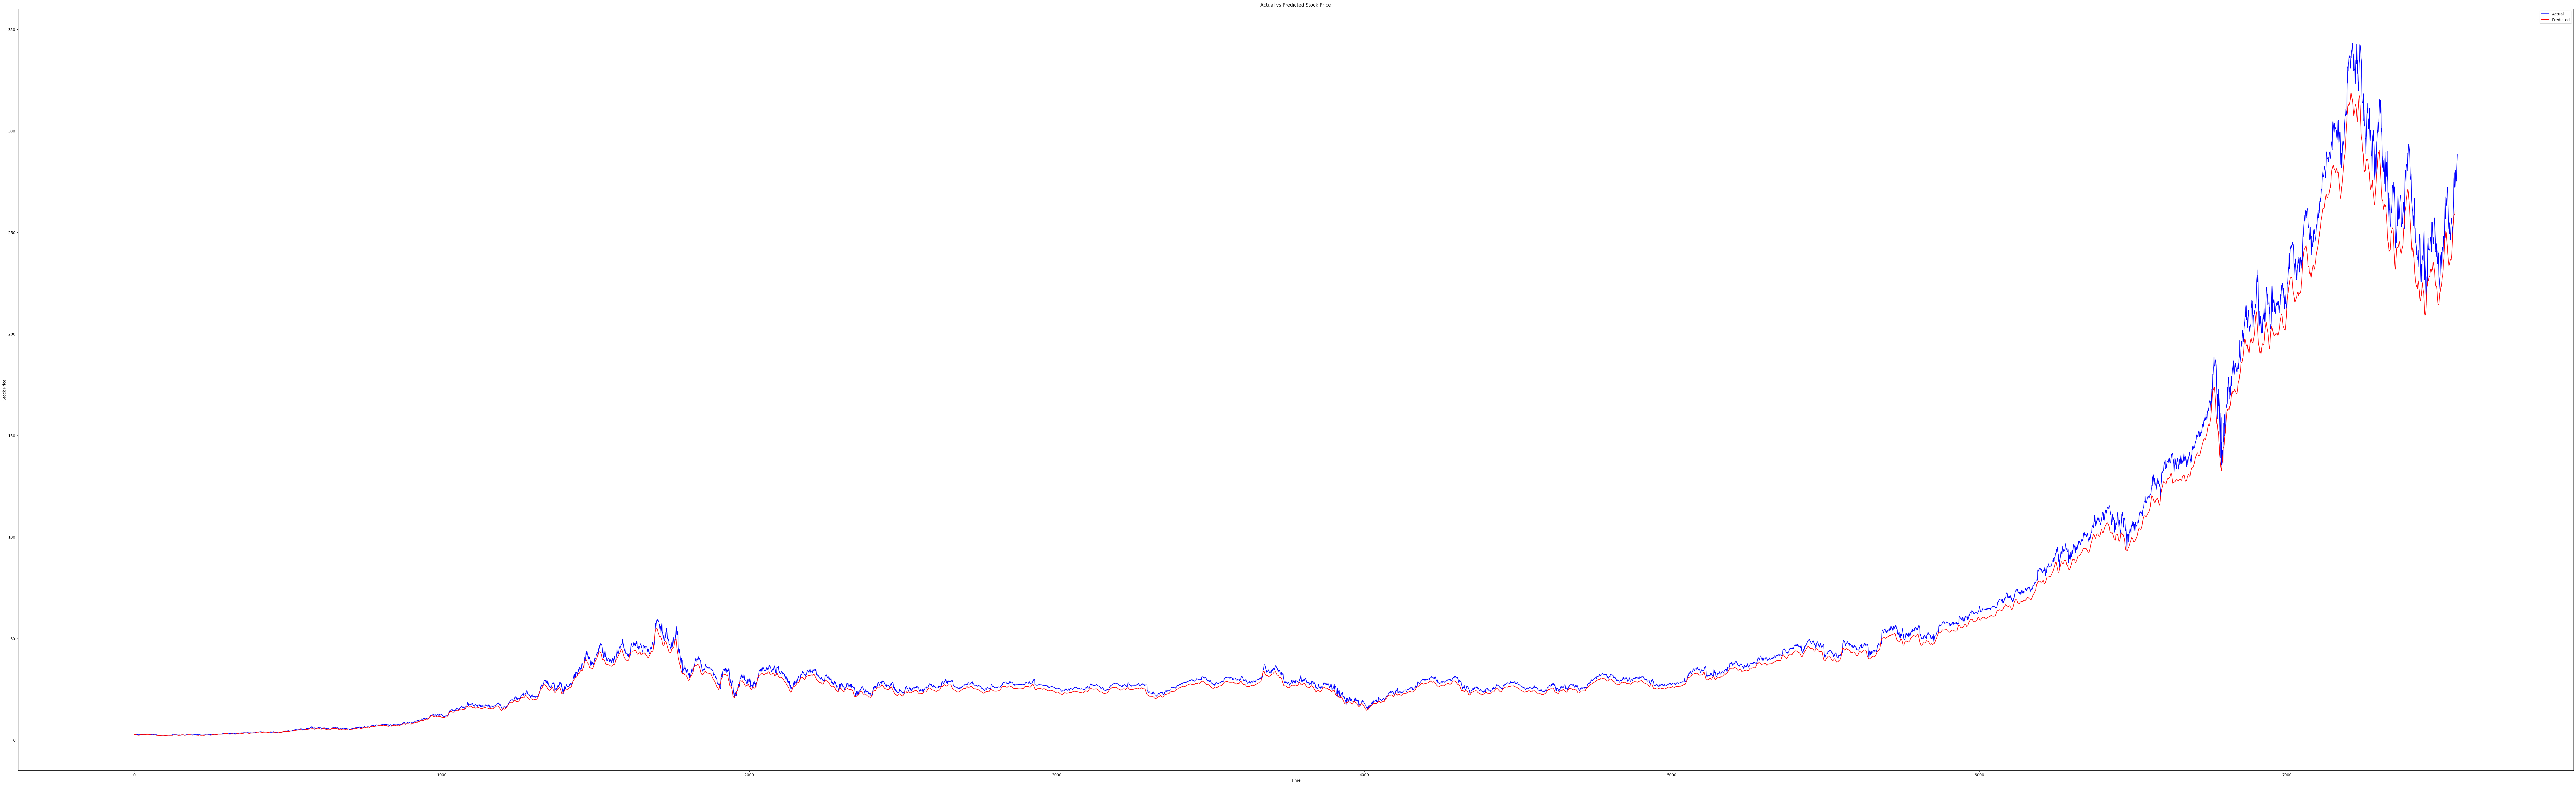

In [168]:
predicted_prices=model.predict(sliding_window(data))
actual_prices=data['Close']
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(120,36))
plt.plot(actual_prices, color='blue', label='Actual')
plt.plot(predicted_prices, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.show()